In [1]:
import os
import cv2 as cv
from pathlib import Path
from PIL import Image
import random
from tqdm import tqdm #to increase iteration speed
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from tensorflow.python.client import device_lib
from sklearn import preprocessing, model_selection
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers, losses, Sequential
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [2]:
print(tf.__version__)

1.10.0


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7756378801693555421
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3156659404
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6937394516226313888
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [6]:
dir_path = 'D:\Freidburg-s-Groceries\images\\'

paths = os.listdir(dir_path)
print(paths)
path_label_list = []
path_list = []
count = -1
for path in paths:
    count+=1
    c = 0
    for i in os.listdir(dir_path+path):
        c+=1
        path_dict = {}
        l_path = path.lower()
        path_dict = {dir_path+path+'/'+i:l_path}
        path_label_list.append(path_dict)
    if count%3 == 2 and count%3!=0:
            print('\n', count, path, len(path_label_list), '\n')
            path_list.append(path_label_list)
            path_label_list = []
    print(l_path, " ", c)
    #print(count, path, len(path_label_list))
#l_path --> object
#path --> path of each category in the DIR_LIB Directory

['CANDY', 'CEREAL', 'CHIPS', 'CHOCOLATE', 'COFFEE', 'CORN', 'FISH', 'FLOUR', 'HONEY', 'JAM', 'JUICE', 'MILK', 'NUTS', 'OIL', 'PASTA', 'RICE', 'SODA', 'SPICES', 'SUGAR', 'TEA', 'TOMATO_SAUCE', 'VINEGAR', 'WATER']
candy   235
cereal   278

 2 CHIPS 694 

chips   181
chocolate   307
coffee   298

 5 CORN 702 

corn   97
fish   110
flour   109

 8 HONEY 404 

honey   185
jam   241
juice   302

 11 MILK 705 

milk   162
nuts   168
oil   143

 14 PASTA 483 

pasta   172
rice   150
soda   177

 17 SPICES 534 

spices   207
sugar   118
tea   283

 20 TOMATO_SAUCE 572 

tomato_sauce   171
vinegar   157
water   262


In [7]:
len(path_list)

7

In [8]:
for p in path_list:
    print(len(p))
#we have 4947 items (close to 10,000)

694
702
404
705
483
534
572


In [9]:
train = []
test = []
path_label_list[:-100]
for path_label_list in path_list:
    d = int(len(path_label_list)*0.1)
    random.shuffle(path_label_list)
    train.append(path_label_list[:-d])
    test.append(path_label_list[len(path_label_list)-d:])

In [10]:
for set in train:
    print(len(set))

625
632
364
635
435
481
515


In [11]:
for set in test:
    print(len(set))

69
70
40
70
48
53
57


In [12]:
row = 100
col = 100
channel = 3

In [13]:
def read_and_process(path_label_list):
    X = []
    y = []
    for path_label in tqdm(path_label_list):
        for img_path in path_label:
            image = cv.resize(cv.imread(img_path, cv.IMREAD_COLOR), (row, col), interpolation=cv.INTER_CUBIC) 
            #scale and push into X
            X.append(image)
            y.append(path_label[img_path])
        path_label
    del path_label_list
    return X, y

In [14]:
X = []
y = []
train_length = len(train)
for i in range(train_length):
    x, Y = read_and_process(train[i])
    X.append(x)
    y.append(Y)

100%|███████████████████████████████████████████████████████████████████████████████| 515/515 [00:01<00:00, 428.87it/s]


In [15]:
del train
gc.collect()

198

Text(0.5, 1.0, 'cereal')

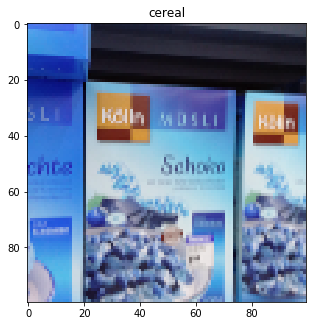

In [16]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5, 15)
plt.imshow(X[0][0])
plt.title(y[0][0])

In [17]:
print(X[0][0].shape)

(100, 100, 3)


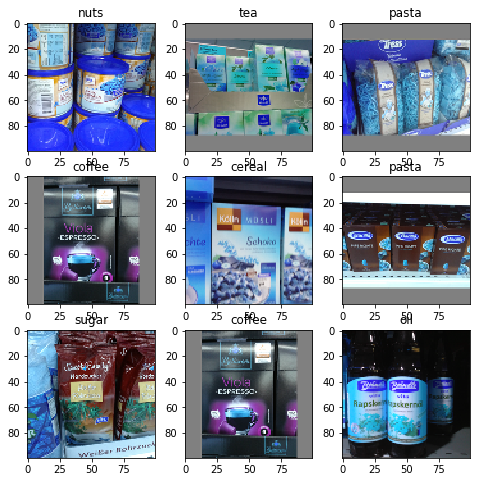

In [18]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(8, 8)
for i in range(3):
    for j in range(3):
        k = np.random.randint(0, len(y))
        l = np.random.randint(0, len(y))
        ax[i, j].imshow(X[k][l])
        ax[i, j].set_title(y[k][l])

In [19]:
import seaborn as sns

C:\Users\rps24\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\rps24\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\rps24\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterp

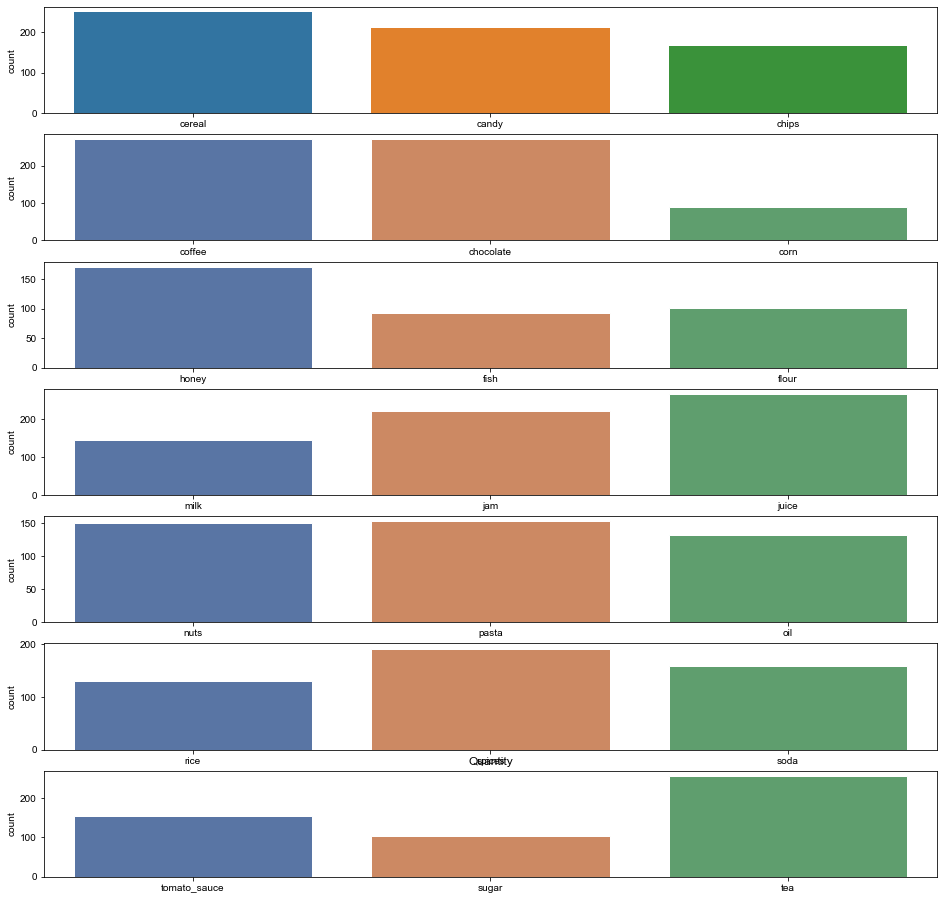

In [20]:
fig, ax = plt.subplots(len(y), 1)
fig.set_size_inches(16, 16)
c = 0
for i in range (len(y)):
    sns.countplot(y[i], ax = ax[c])
    sns.set(rc={'figure.figsize':(21.7,18.0)}, font_scale=1)
    plt.title('Quantity')
    c+=1

In [21]:
#conclusion: most data for candy, least data for corn... this is a classic imbalanced classification problem 
#This can be handled by Data Augmentation

In [22]:
label_maker = preprocessing.LabelEncoder()

In [23]:
def preprocess_one_items(X, y, i):
    if i>=len(X):
        return
    else:
        print(np.unique(y[i]))
        print()
        Y = label_maker.fit_transform(y[i])
        y[i] = Y
        print(np.unique(Y))
        print()
        X_train, X_val, y_train, y_val = model_selection.train_test_split(X[i], y[i], test_size = 0.1, random_state=56)
        print()
        print('X_TRAIN LENGTH: ', len(X_train))
        print('X_VAL LENGTH: ', len(X_val))
        print('Y_TRAIN LENGTH: ', len(y_train))
        print('Y_VAL LENGTH: ', len(y_val))    
        print()
        print(len(X))
        print(len(y))
        return X_train, X_val, y_train, y_val

In [24]:
gc.collect()

18435

In [25]:
test_X = []
test_y = []
test_length = len(test)
for i in range(test_length):
    x, Y = read_and_process(test[i])
    test_X.append(x)
    test_y.append(Y)

100%|█████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 436.28it/s]


In [26]:
del test
gc.collect()

197

In [27]:
def test_list(i):
    x_test = np.array(test_X[i])
    Y_test = np.array(label_maker.fit_transform(test_y[i]))
    test_generator = ImageDataGenerator(rescale=1/255.)
    test_gen = test_generator.flow(x_test,
                            shuffle=False
                                  )
    return test_gen, x_test, Y_test

In [28]:
#Data Augmentation: is a technique generally used to increase data size
#Data Augmentation: increases generality, thus making predictions more reliable

In [29]:
def data_augmentation(X, y, i):
    X_train, X_val, y_train, y_val = preprocess_one_items(X, y, i)
    X_train = np.asarray(X_train)
    print("\nX_train.shape(): ", X_train.shape)
    X_val = np.asarray(X_val)
    print("X_val.shape(): ", X_val.shape)
    train_generator = ImageDataGenerator(rescale=1/255,
                                     rotation_range=0.1, 
                                     width_shift_range=0.1,
                                     height_shift_range=0.1, 
                                     zoom_range=20, 
                                     horizontal_flip='True', 
                                     vertical_flip='True',
                                     validation_split=0.2)

    val_generator = ImageDataGenerator(rescale=1/255)
    #We alter train based on many factors
    #we don't alter val 
    #what is rescaling? - Normalisation
    train_gen = train_generator.flow(X_train, y_train)
    val_gen = val_generator.flow(X_val, y_val)
    return train_gen, val_gen, len(X_train), len(X_val)
    #what does flow do? 
    #flow

In [30]:
def vgg16_model(y, i, neurons):
    vgg16 = VGG16(weights = 'imagenet', include_top=False, input_tensor = layers.Input(shape=(row, col, channel)))
    print(vgg16.summary())
    print("\n\n")
    for layer in vgg16.layers:
        layer.trainable = False
        #to freeze layers
        print(layer.__class__.__name__, layer.trainable)
    bottom = vgg16.layers[-3].output #stores the output of the penultimate layer
    print("\n bottom:", bottom)
    bottom = layers.Flatten()(bottom)
    bottom = layers.Dropout(0.5)(bottom)
    bottom = layers.Dense(neurons, activation='relu')(bottom)
    bottom = layers.Dense(neurons, activation='relu')(bottom)
    output = layers.Dense(len(np.unique(y[i])), activation='softmax')(bottom)
    print("\n output: ", output)
    model  = models.Model(input=vgg16.input, output=output)
    return model

In [31]:
def plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, 1+len(acc))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Epochs vs Accuracy to compare Accuracy between Training and Validation')
    plt.legend()
    plt.plot(epochs, loss, 'y', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Epochs vs Loss to compare the Loss between Training and Validation')
    plt.legend()
    del history

In [32]:
def predict_and_evaluate(test_gen, X_test, y_test, model):
    predictions = model.predict_generator(test_gen, steps = len(X_test), use_multiprocessing=False) 
    #returns probability distribution
    classes = np.argmax(predictions, axis = 1)
    print(classes)
    np.set_printoptions(threshold=np.inf)
    print(label_maker.inverse_transform(classes))
    print('evaluate: ',model.evaluate(X_test, y_test))
    print(model.metrics_names)#what do the evaluate output mean?
    del X_test
    del y_test
    del model
    gc.collect()

In [33]:
batch_size_1 = 16
batch_size_2 = 32
batch_size_3 = 64
batch_size_4 = 128
gc.collect()

0

In [34]:
neurons_1 = 256
neurons_2 = 512
neurons_3 = 1024
neurons_4 = 2048
neurons_5 = 4096

In [35]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [36]:
#-------------------------------------------------MODEL 1--------------------------------------------------------#

In [37]:
gc.collect()
K.clear_session()

In [115]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [116]:
gc.collect()

0

In [117]:
train_gen_1, val_gen_1, train_len, val_len = data_augmentation(X, y, 0)
groceries_model_1 = vgg16_model(y, 0, neurons_2)
groceries_model_1.summary()

[0 1 2]

[0 1 2]


X_TRAIN LENGTH:  562
X_VAL LENGTH:  63
Y_TRAIN LENGTH:  562
Y_VAL LENGTH:  63

7
7

X_train.shape():  (562, 100, 100, 3)
X_val.shape():  (63, 100, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None

C:\Users\rps24\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [118]:
checkpoint = ModelCheckpoint("h5 files\groceries_1.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')

In [119]:
groceries_model_1.compile(loss='sparse_categorical_crossentropy', optimizer = optimizers.Adam(lr=1e-4), metrics = ['acc'])

In [120]:
history_1 = groceries_model_1.fit_generator(generator= train_gen_1, 
                                 steps_per_epoch= train_len//batch_size_2, 
                                 epochs=batch_size_2, 
                                 validation_data= val_gen_1, 
                                 validation_steps=val_len//batch_size_2, 
                                 callbacks=[checkpoint,early])

Epoch 1/32
17/17 [==============================] - 2s 142ms/step - loss: 1.1498 - acc: 0.4163 - val_loss: 0.9493 - val_acc: 0.5938

Epoch 00001: val_acc improved from -inf to 0.59375, saving model to h5 files\groceries_1.h5
Epoch 2/32
17/17 [==============================] - 2s 118ms/step - loss: 0.9662 - acc: 0.5699 - val_loss: 0.9386 - val_acc: 0.6562

Epoch 00002: val_acc improved from 0.59375 to 0.65625, saving model to h5 files\groceries_1.h5
Epoch 3/32
17/17 [==============================] - 2s 115ms/step - loss: 0.9352 - acc: 0.5899 - val_loss: 0.9345 - val_acc: 0.6250

Epoch 00003: val_acc did not improve from 0.65625
Epoch 4/32
17/17 [==============================] - 2s 117ms/step - loss: 0.9839 - acc: 0.5369 - val_loss: 0.9488 - val_acc: 0.6875

Epoch 00004: val_acc improved from 0.65625 to 0.68750, saving model to h5 files\groceries_1.h5
Epoch 5/32
17/17 [==============================] - 2s 119ms/step - loss: 0.9737 - acc: 0.5478 - val_loss: 0.9999 - val_acc: 0.5312

Epo

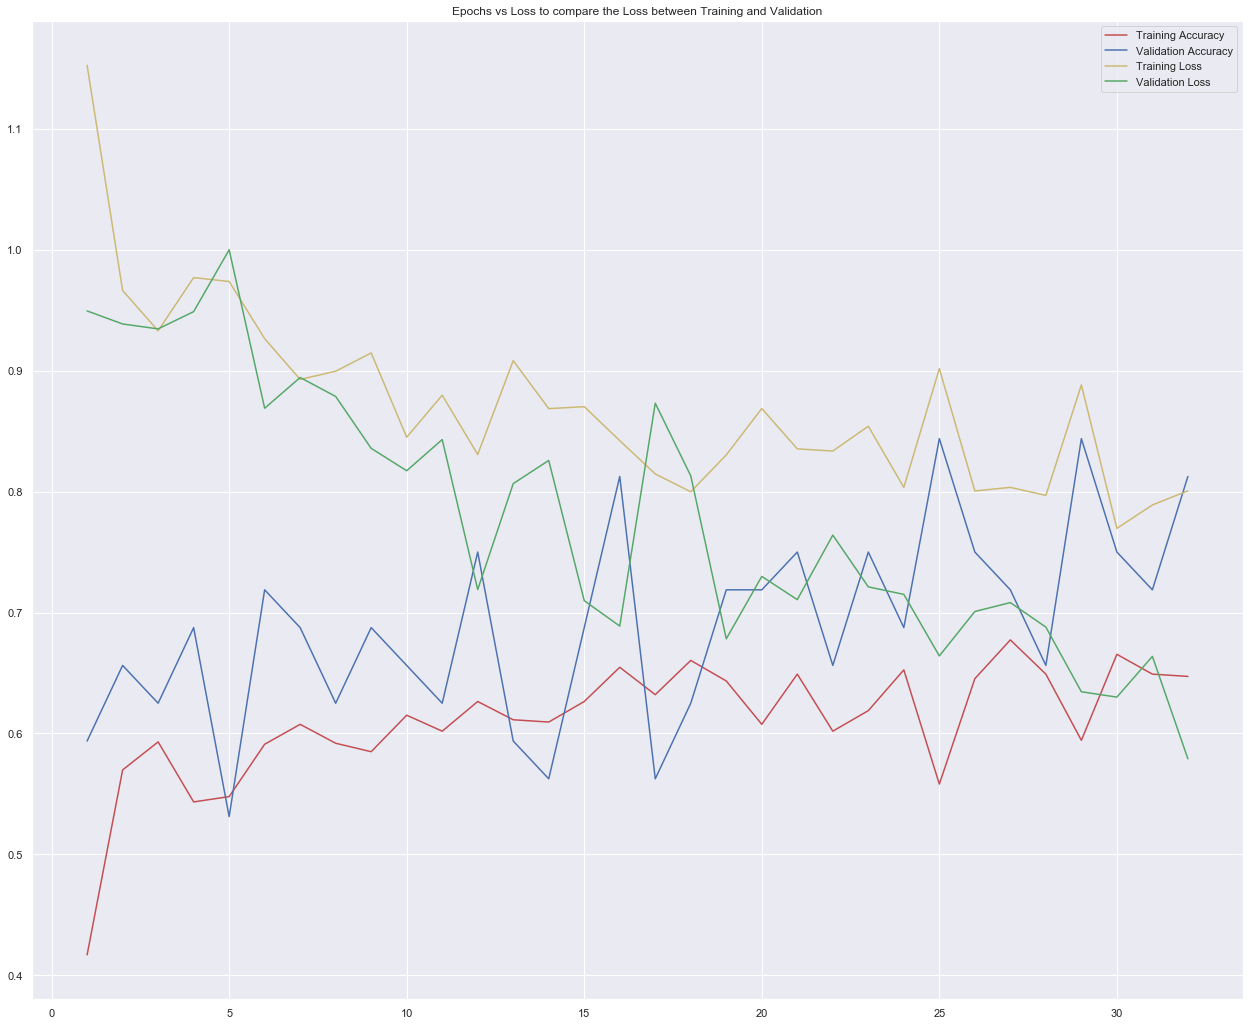

In [121]:
plot(history_1)

In [122]:
groceries_model_1 = models.load_model('h5 files\groceries_1.h5')

In [123]:
gc.collect()

15397

In [124]:
test_gen, X_test, y_test = test_list(0)
predict_and_evaluate(test_gen, X_test, y_test, groceries_model_1)

[1 1 0 2 1 1 2 2 2 0 1 1 2 0 1 1 1 0 2 0 0 0 2 1 0 0 0 2 0 0 2 0 0 1 2 0 1
 1 0 2 1 2 1 0 2 2 0 0 2 1 0 1 1 1 0 1 2 1 2 1 0 1 1 2 2 2 1 0 1 1 1 0 2 1
 1 2 2 2 0 1 1 2 0 1 1 1 0 2 0 0 0 2 1 0 0 0 2 0 0 2 0 0 1 2 0 1 1 0 2 1 2
 1 0 2 2 0 0 2 1 0 1 1 1 0 1 2 1 2 1 0 1 1 2 2 2 1 0 1 1 1 0 2 1 1 2 2 2 0
 1 1 2 0 1 1 1 0 2 0 0 0 2 1 0 0 0 2 0 0 2 0 0 1 2 0 1 1 0 2 1 2 1 0 2 2 0
 0 2 1 0 1 1 1 0 1 2 1 2 1 0 1 1 2 2 2 1 0 1 1 1 0 2 1 1 2 2 2 0 1 1 2 0 1
 1 1 0 2 0 0 0 2 1 0 0 0 2 0 0 2 0 0 1 2 0 1 1 0 2 1 2 1 0 2 2 0 0 2 1 0 1
 1 1 0 1 2 1 2 1 0 1 1 2 2 2 1 0 1 1 1 0 2 1 1 2 2 2 0 1 1 2 0 1 1 1 0 2 0
 0 0 2 1 0 0 0 2 0 0 2 0 0 1 2 0 1 1 0 2 1 2 1 0 2 2 0 0 2 1 0 1 1 1 0 1 2
 1 2 1 0 1 1 2 2 2 1 0 1 1 1 0 2 1 1 2 2 2 0 1 1 2 0 1 1 1 0 2 0 0 0 2 1 0
 0 0 2 0 0 2 0 0 1 2 0 1 1 0 2 1 2 1 0 2 2 0 0 2 1 0 1 1 1 0 1 2 1 2 1 0 1
 1 2 2 2 1 0 1 1 1 0 2 1 1 2 2 2 0 1 1 2 0 1 1 1 0 2 0 0 0 2 1 0 0 0 2 0 0
 2 0 0 1 2 0 1 1 0 2 1 2 1 0 2 2 0 0 2 1 0 1 1 1 0 1 2 1 2 1 0 1 1 2 2 2 1
 0 1 1 1 0 2 1 1 2 2 2 0 

69/69 [==============================] - 0s 4ms/step
evaluate:  [6.225657912268155, 0.5942028994145601]
['loss', 'acc']


In [38]:
#-------------------------------------------------MODEL 2------------------------------------------------------#

In [39]:
K.clear_session()

In [40]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [41]:
train_gen_2, val_gen_2, train_len, val_len = data_augmentation(X, y, 1)
groceries_model_2 = vgg16_model(y, 1, neurons_2)
groceries_model_2.summary()

['chocolate' 'coffee' 'corn']

[0 1 2]


X_TRAIN LENGTH:  568
X_VAL LENGTH:  64
Y_TRAIN LENGTH:  568
Y_VAL LENGTH:  64

7
7

X_train.shape():  (568, 100, 100, 3)
X_val.shape():  (64, 100, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2

C:\Users\rps24\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [42]:
groceries_model_2.compile(loss='sparse_categorical_crossentropy', optimizer = optimizers.Adam(lr=1e-4), metrics = ['acc'])

In [43]:
checkpoint = ModelCheckpoint("h5 files\groceries_2.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')

In [44]:
history_2 = groceries_model_2.fit_generator(generator= train_gen_2, 
                                 steps_per_epoch= train_len//batch_size_2, 
                                 epochs= batch_size_2, 
                                 validation_data= val_gen_2, 
                                 validation_steps=val_len//batch_size_2, 
                                 callbacks=[checkpoint,early])

Epoch 1/32
17/17 [==============================] - 4s 259ms/step - loss: 0.9666 - acc: 0.5238 - val_loss: 1.1256 - val_acc: 0.4688

Epoch 00001: val_acc improved from -inf to 0.46875, saving model to h5 files\groceries_2.h5
Epoch 2/32
17/17 [==============================] - 2s 115ms/step - loss: 0.8721 - acc: 0.5699 - val_loss: 1.0722 - val_acc: 0.4688

Epoch 00002: val_acc did not improve from 0.46875
Epoch 3/32
17/17 [==============================] - 2s 117ms/step - loss: 0.9018 - acc: 0.5362 - val_loss: 0.9601 - val_acc: 0.6719

Epoch 00003: val_acc improved from 0.46875 to 0.67188, saving model to h5 files\groceries_2.h5
Epoch 4/32
17/17 [==============================] - 2s 119ms/step - loss: 0.8976 - acc: 0.5851 - val_loss: 0.9294 - val_acc: 0.5938

Epoch 00004: val_acc did not improve from 0.67188
Epoch 5/32
17/17 [==============================] - 2s 118ms/step - loss: 0.8777 - acc: 0.5527 - val_loss: 0.9563 - val_acc: 0.4688

Epoch 00005: val_acc did not improve from 0.6718

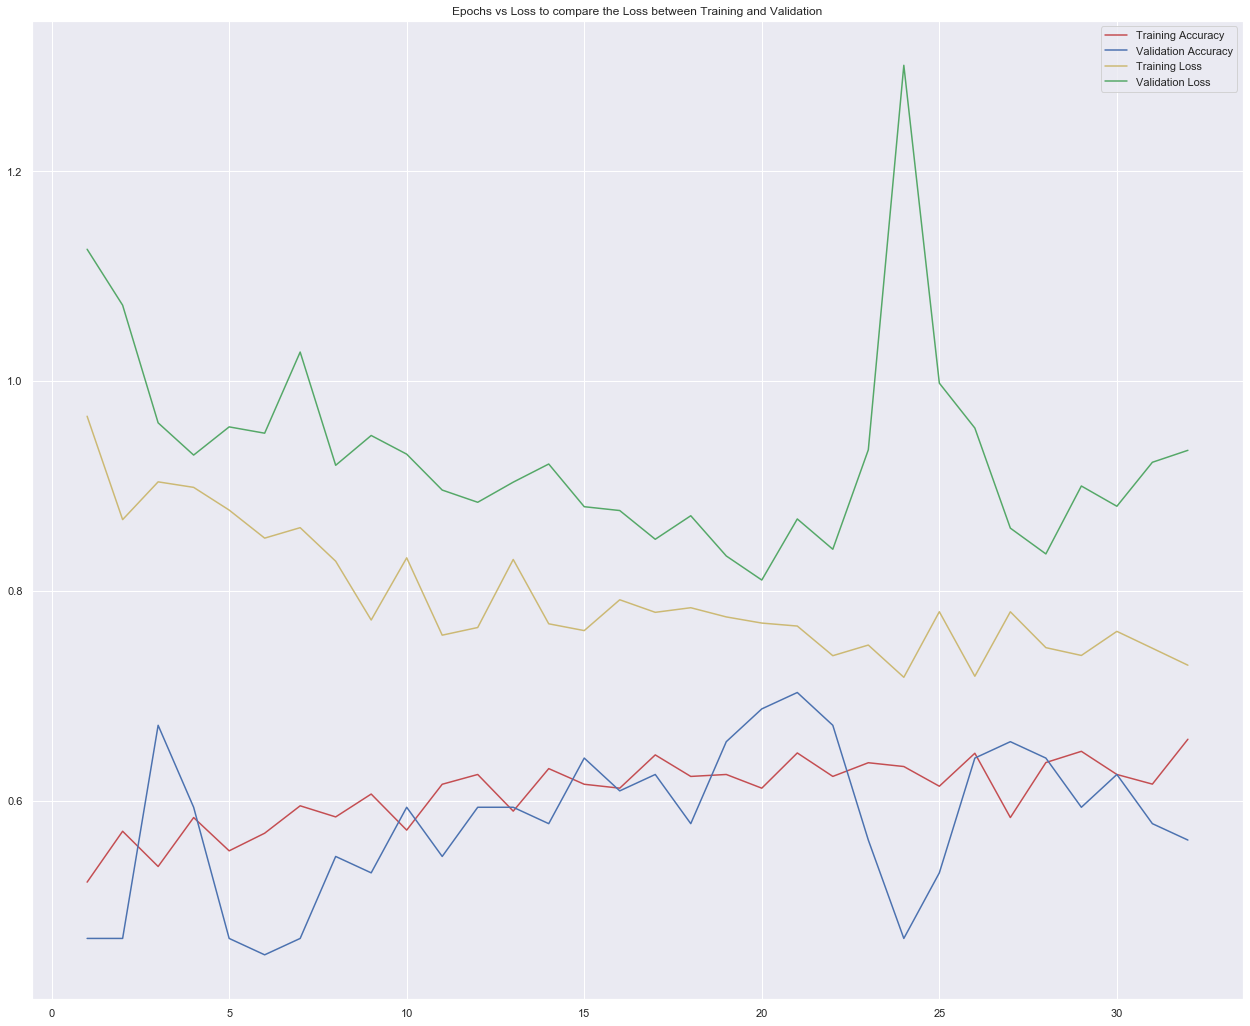

In [45]:
plot(history_2)

In [46]:
groceries_model_2 = models.load_model('h5 files\groceries_2.h5')

In [47]:
test_gen, X_test, y_test = test_list(1)
predict_and_evaluate(test_gen, X_test, y_test, groceries_model_2)

[0 2 1 ... 0 0 1]
['chocolate' 'corn' 'coffee' 'chocolate' 'coffee' 'chocolate' 'coffee'
 'chocolate' 'coffee' 'chocolate' 'chocolate' 'coffee' 'coffee' 'coffee'
 'coffee' 'coffee' 'chocolate' 'chocolate' 'chocolate' 'chocolate'
 'chocolate' 'chocolate' 'chocolate' 'chocolate' 'coffee' 'coffee'
 'coffee' 'coffee' 'coffee' 'chocolate' 'chocolate' 'coffee' 'chocolate'
 'chocolate' 'chocolate' 'coffee' 'chocolate' 'coffee' 'chocolate'
 'coffee' 'chocolate' 'coffee' 'coffee' 'coffee' 'coffee' 'corn' 'coffee'
 'chocolate' 'chocolate' 'coffee' 'chocolate' 'coffee' 'coffee'
 'chocolate' 'chocolate' 'coffee' 'chocolate' 'coffee' 'coffee' 'coffee'
 'coffee' 'chocolate' 'coffee' 'chocolate' 'coffee' 'coffee' 'chocolate'
 'chocolate' 'chocolate' 'coffee' 'chocolate' 'corn' 'coffee' 'chocolate'
 'coffee' 'chocolate' 'coffee' 'chocolate' 'coffee' 'chocolate'
 'chocolate' 'coffee' 'coffee' 'coffee' 'coffee' 'coffee' 'chocolate'
 'chocolate' 'chocolate' 'chocolate' 'chocolate' 'chocolate' 'chocolate'

70/70 [==============================] - 0s 3ms/step
evaluate:  [5.855814608670438, 0.6]
['loss', 'acc']


In [48]:
gc.collect()

0

In [216]:
#-------------------------------------------------MODEL 3------------------------------------------------------#

In [73]:
K.clear_session()

In [74]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [75]:
train_gen_3, val_gen_3, train_len, val_len = data_augmentation(X, y, 2)
groceries_model_3 = vgg16_model(y, 2, neurons_2)
groceries_model_3.summary()

[0 1 2]

[0 1 2]


X_TRAIN LENGTH:  327
X_VAL LENGTH:  37
Y_TRAIN LENGTH:  327
Y_VAL LENGTH:  37

7
7

X_train.shape():  (327, 100, 100, 3)
X_val.shape():  (37, 100, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None

C:\Users\rps24\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [76]:
groceries_model_3.compile(loss='sparse_categorical_crossentropy', optimizer = optimizers.Adam(lr=1e-4), metrics = ['acc'])

In [77]:
gc.collect()

5737

In [78]:
checkpoint = ModelCheckpoint("h5 files\groceries_3.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')

In [79]:
os.path.exists("h5 files\groceries_3.h5")

True

In [80]:
history_3 = groceries_model_3.fit_generator(generator= train_gen_3, 
                                 steps_per_epoch= train_len//batch_size_1, 
                                 epochs= batch_size_1, 
                                 validation_data= val_gen_3, 
                                 validation_steps= val_len//batch_size_1, 
                                 callbacks=[checkpoint,early])

Epoch 1/16
20/20 [==============================] - 8s 421ms/step - loss: 1.0923 - acc: 0.5141 - val_loss: 0.9858 - val_acc: 0.5135

Epoch 00001: val_acc improved from -inf to 0.51351, saving model to h5 files\groceries_3.h5
Epoch 2/16
20/20 [==============================] - 7s 328ms/step - loss: 0.9683 - acc: 0.5132 - val_loss: 0.8256 - val_acc: 0.6216

Epoch 00002: val_acc improved from 0.51351 to 0.62162, saving model to h5 files\groceries_3.h5
Epoch 3/16
20/20 [==============================] - 7s 333ms/step - loss: 0.8677 - acc: 0.5839 - val_loss: 0.7379 - val_acc: 0.6216

Epoch 00003: val_acc did not improve from 0.62162
Epoch 4/16
20/20 [==============================] - 6s 308ms/step - loss: 0.8612 - acc: 0.5532 - val_loss: 0.7424 - val_acc: 0.6216

Epoch 00004: val_acc did not improve from 0.62162
Epoch 5/16
20/20 [==============================] - 7s 331ms/step - loss: 0.8427 - acc: 0.5729 - val_loss: 0.6482 - val_acc: 0.7027

Epoch 00005: val_acc improved from 0.62162 to 0.

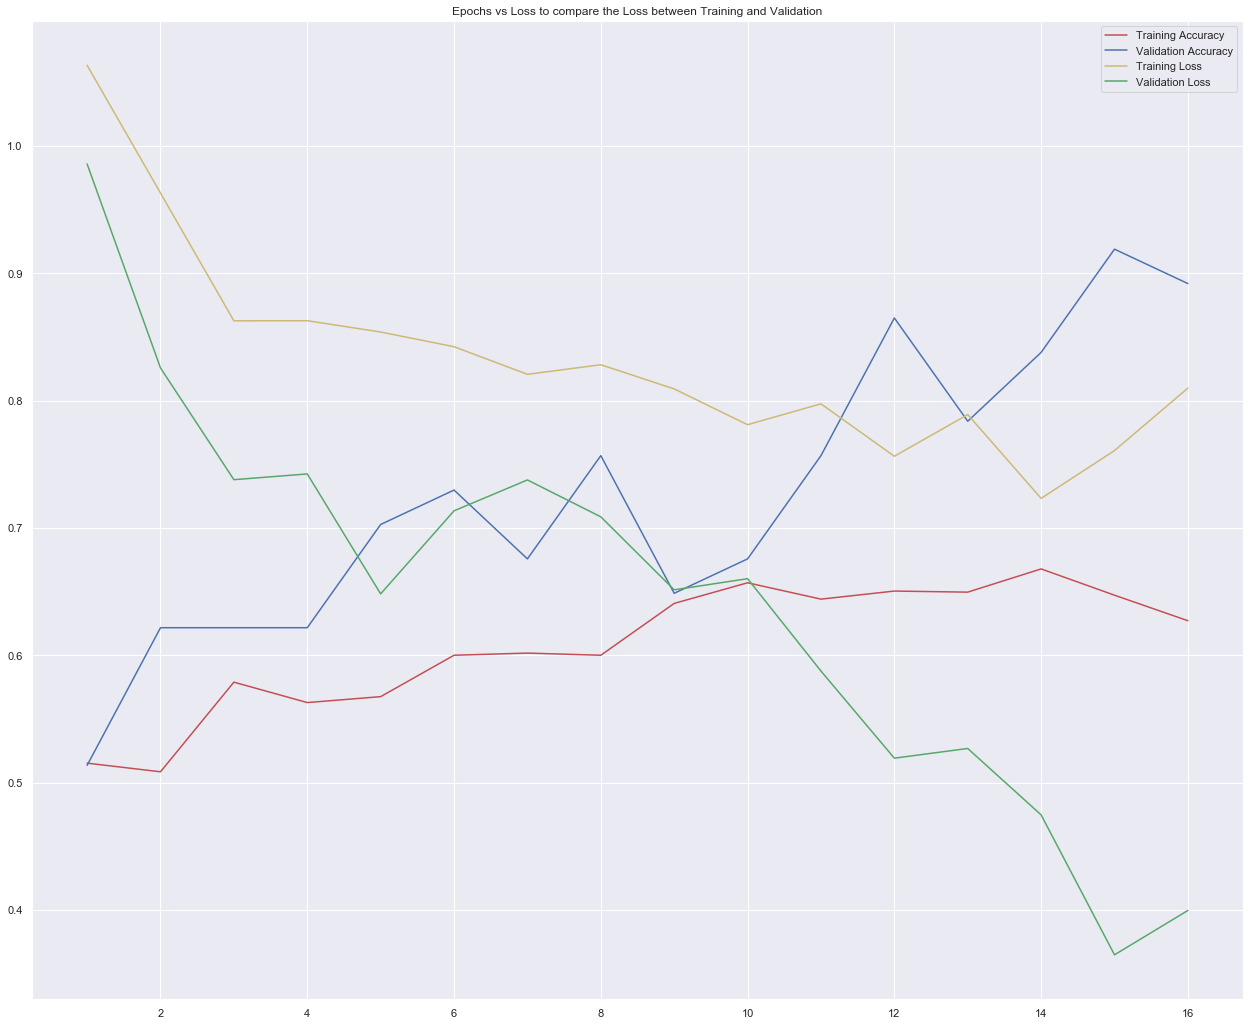

In [81]:
plot(history_3)

In [82]:
gc.collect()

5422

In [83]:
groceries_model_3 = models.load_model('h5 files\groceries_3.h5')

In [84]:
test_gen, X_test, y_test = test_list(2)
predict_and_evaluate(test_gen, X_test, y_test, groceries_model_3)

[0 1 2 2 0 2 2 1 2 1 2 2 2 2 2 1 2 0 0 0 0 0 1 2 2 2 1 0 2 1 0 2 2 0 2 2 1
 1 2 2 0 1 2 2 0 2 2 1 2 1 2 2 2 2 2 1 2 0 0 0 0 0 1 2 2 2 1 0 2 1 0 2 2 0
 2 2 1 1 2 2 0 1 2 2 0 2 2 1 2 1 2 2 2 2 2 1 2 0 0 0 0 0 1 2 2 2 1 0 2 1 0
 2 2 0 2 2 1 1 2 2 0 1 2 2 0 2 2 1 2 1 2 2 2 2 2 1 2 0 0 0 0 0 1 2 2 2 1 0
 2 1 0 2 2 0 2 2 1 1 2 2 0 1 2 2 0 2 2 1 2 1 2 2 2 2 2 1 2 0 0 0 0 0 1 2 2
 2 1 0 2 1 0 2 2 0 2 2 1 1 2 2 0 1 2 2 0 2 2 1 2 1 2 2 2 2 2 1 2 0 0 0 0 0
 1 2 2 2 1 0 2 1 0 2 2 0 2 2 1 1 2 2 0 1 2 2 0 2 2 1 2 1 2 2 2 2 2 1 2 0 0
 0 0 0 1 2 2 2 1 0 2 1 0 2 2 0 2 2 1 1 2 2 0 1 2 2 0 2 2 1 2 1 2 2 2 2 2 1
 2 0 0 0 0 0 1 2 2 2 1 0 2 1 0 2 2 0 2 2 1 1 2 2 0 1 2 2 0 2 2 1 2 1 2 2 2
 2 2 1 2 0 0 0 0 0 1 2 2 2 1 0 2 1 0 2 2 0 2 2 1 1 2 2 0 1 2 2 0 2 2 1 2 1
 2 2 2 2 2 1 2 0 0 0 0 0 1 2 2 2 1 0 2 1 0 2 2 0 2 2 1 1 2 2 0 1 2 2 0 2 2
 1 2 1 2 2 2 2 2 1 2 0 0 0 0 0 1 2 2 2 1 0 2 1 0 2 2 0 2 2 1 1 2 2 0 1 2 2
 0 2 2 1 2 1 2 2 2 2 2 1 2 0 0 0 0 0 1 2 2 2 1 0 2 1 0 2 2 0 2 2 1 1 2 2 0
 1 2 2 0 2 2 1 2 1 2 2 2 

In [252]:
#-----------------------------------------------------MODEL 4-------------------------------------------------------------#

In [61]:
gc.collect()
K.clear_session()

In [62]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [63]:
train_gen_4, val_gen_4, train_len, val_len = data_augmentation(X, y, 3)
groceries_model_4 = vgg16_model(y, 3, neurons_2)
groceries_model_4.summary()

['jam' 'juice' 'milk']

[0 1 2]


X_TRAIN LENGTH:  571
X_VAL LENGTH:  64
Y_TRAIN LENGTH:  571
Y_VAL LENGTH:  64

7
7

X_train.shape():  (571, 100, 100, 3)
X_val.shape():  (64, 100, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2

C:\Users\rps24\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [64]:
groceries_model_4.compile(loss='sparse_categorical_crossentropy', optimizer = optimizers.Adam(lr=1e-4), metrics = ['acc'])

In [65]:
checkpoint = ModelCheckpoint("h5 files\groceries_4.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')

In [66]:
history_4 = groceries_model_4.fit_generator(generator= train_gen_4, 
                                 steps_per_epoch= train_len//batch_size_2, 
                                 epochs= batch_size_2, 
                                 validation_data= val_gen_4, 
                                 validation_steps=val_len//batch_size_2, 
                                 callbacks=[checkpoint,early])

Epoch 1/32
17/17 [==============================] - 3s 170ms/step - loss: 1.0910 - acc: 0.4708 - val_loss: 1.0640 - val_acc: 0.4688

Epoch 00001: val_acc improved from -inf to 0.46875, saving model to h5 files\groceries_4.h5
Epoch 2/32
17/17 [==============================] - 2s 121ms/step - loss: 0.9582 - acc: 0.5455 - val_loss: 0.8086 - val_acc: 0.6406

Epoch 00002: val_acc improved from 0.46875 to 0.64062, saving model to h5 files\groceries_4.h5
Epoch 3/32
17/17 [==============================] - 2s 117ms/step - loss: 0.9651 - acc: 0.5680 - val_loss: 0.8579 - val_acc: 0.6406

Epoch 00003: val_acc did not improve from 0.64062
Epoch 4/32
17/17 [==============================] - 2s 117ms/step - loss: 0.8728 - acc: 0.6163 - val_loss: 0.8846 - val_acc: 0.5938

Epoch 00004: val_acc did not improve from 0.64062
Epoch 5/32
17/17 [==============================] - 2s 119ms/step - loss: 0.9004 - acc: 0.6014 - val_loss: 0.9807 - val_acc: 0.5469

Epoch 00005: val_acc did not improve from 0.6406

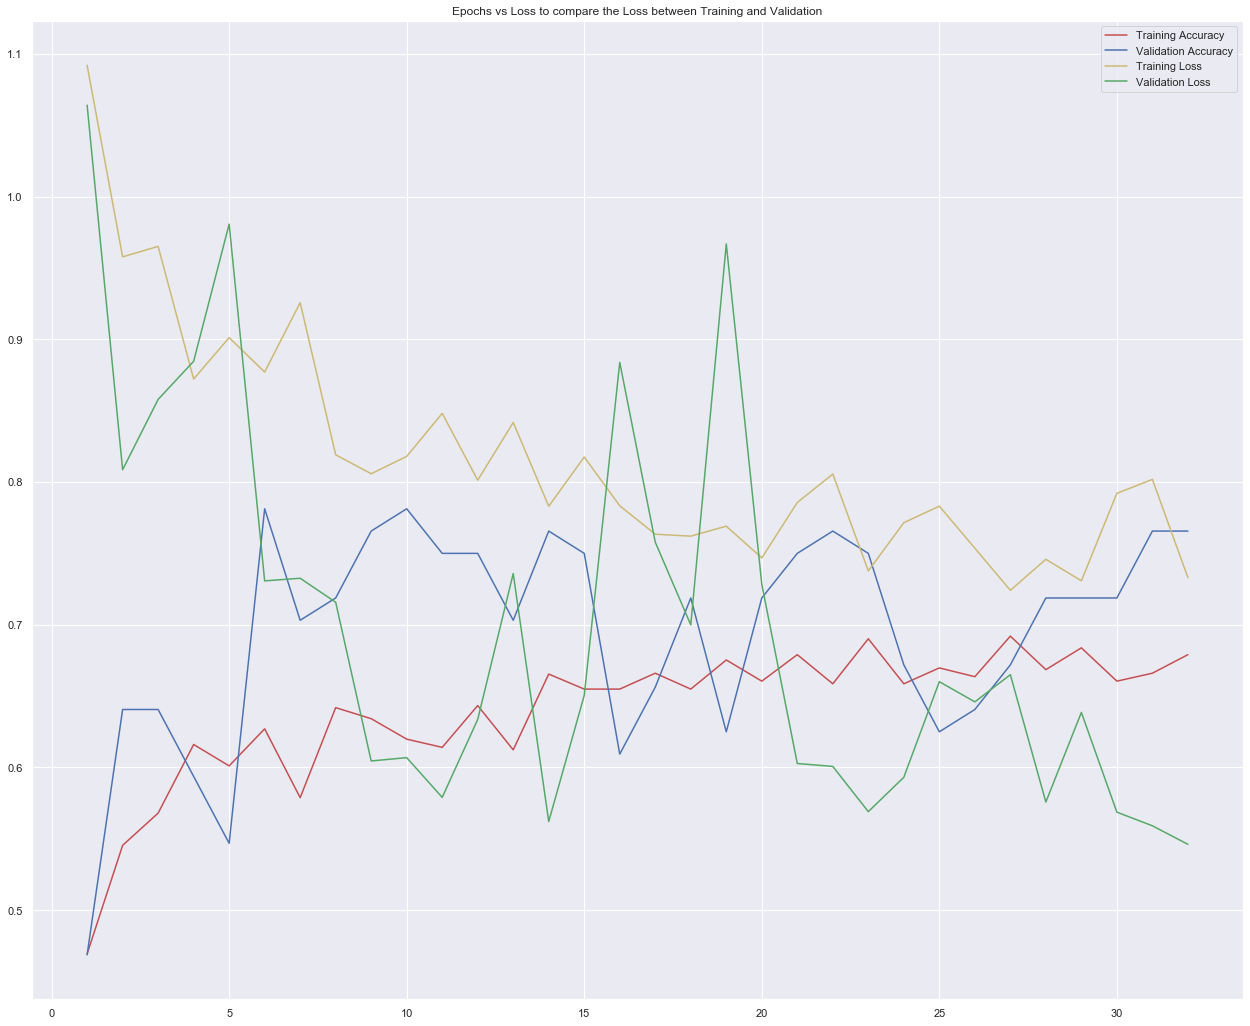

In [67]:
plot(history_4)

In [68]:
groceries_model_4 = models.load_model('h5 files/groceries_4.h5')

In [69]:
test_gen, X_test, y_test = test_list(3)
predict_and_evaluate(test_gen, X_test, y_test, groceries_model_4)

[1 0 2 2 2 0 0 2 2 0 0 2 2 0 2 1 0 0 2 1 0 1 2 1 0 2 2 0 1 2 2 1 2 1 1 2 1
 1 1 0 2 1 0 0 0 2 0 2 2 0 2 1 2 2 1 0 2 1 2 1 2 1 2 1 1 0 2 2 0 2 1 0 2 2
 2 0 0 2 2 0 0 2 2 0 2 1 0 0 2 1 0 1 2 1 0 2 2 0 1 2 2 1 2 1 1 2 1 1 1 0 2
 1 0 0 0 2 0 2 2 0 2 1 2 2 1 0 2 1 2 1 2 1 2 1 1 0 2 2 0 2 1 0 2 2 2 0 0 2
 2 0 0 2 2 0 2 1 0 0 2 1 0 1 2 1 0 2 2 0 1 2 2 1 2 1 1 2 1 1 1 0 2 1 0 0 0
 2 0 2 2 0 2 1 2 2 1 0 2 1 2 1 2 1 2 1 1 0 2 2 0 2 1 0 2 2 2 0 0 2 2 0 0 2
 2 0 2 1 0 0 2 1 0 1 2 1 0 2 2 0 1 2 2 1 2 1 1 2 1 1 1 0 2 1 0 0 0 2 0 2 2
 0 2 1 2 2 1 0 2 1 2 1 2 1 2 1 1 0 2 2 0 2 1 0 2 2 2 0 0 2 2 0 0 2 2 0 2 1
 0 0 2 1 0 1 2 1 0 2 2 0 1 2 2 1 2 1 1 2 1 1 1 0 2 1 0 0 0 2 0 2 2 0 2 1 2
 2 1 0 2 1 2 1 2 1 2 1 1 0 2 2 0 2 1 0 2 2 2 0 0 2 2 0 0 2 2 0 2 1 0 0 2 1
 0 1 2 1 0 2 2 0 1 2 2 1 2 1 1 2 1 1 1 0 2 1 0 0 0 2 0 2 2 0 2 1 2 2 1 0 2
 1 2 1 2 1 2 1 1 0 2 2 0 2 1 0 2 2 2 0 0 2 2 0 0 2 2 0 2 1 0 0 2 1 0 1 2 1
 0 2 2 0 1 2 2 1 2 1 1 2 1 1 1 0 2 1 0 0 0 2 0 2 2 0 2 1 2 2 1 0 2 1 2 1 2
 1 2 1 1 0 2 2 0 2 1 0 2 

70/70 [==============================] - 0s 3ms/step
evaluate:  [3.7136323520115444, 0.7142857159887042]
['loss', 'acc']


In [37]:
#---------------------------------------------------MODEL 5-----------------------------------------------------------#

In [70]:
gc.collect()
K.clear_session()

In [71]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [72]:
train_gen_5, val_gen_5, train_len, val_len = data_augmentation(X, y, 4)
groceries_model_5 = vgg16_model(y, 4, neurons_2)
groceries_model_5.summary()

['nuts' 'oil' 'pasta']

[0 1 2]


X_TRAIN LENGTH:  391
X_VAL LENGTH:  44
Y_TRAIN LENGTH:  391
Y_VAL LENGTH:  44

7
7

X_train.shape():  (391, 100, 100, 3)
X_val.shape():  (44, 100, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2

C:\Users\rps24\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [60]:
groceries_model_5.compile(loss='sparse_categorical_crossentropy', optimizer = optimizers.Adam(lr=1e-4), metrics = ['acc'])

In [61]:
checkpoint = ModelCheckpoint("h5 files\groceries_5.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')

In [62]:
gc.collect()

5223

In [63]:
history_5 = groceries_model_5.fit_generator(generator= train_gen_5, 
                                 steps_per_epoch= train_len//batch_size_1, 
                                 epochs= batch_size_1, 
                                 validation_data= val_gen_5, 
                                 validation_steps=val_len//batch_size_1, 
                                 callbacks=[checkpoint,early])

Epoch 1/16
24/24 [==============================] - 9s 374ms/step - loss: 1.1679 - acc: 0.4232 - val_loss: 1.0986 - val_acc: 0.4773

Epoch 00001: val_acc improved from -inf to 0.47727, saving model to h5 files\groceries_5.h5
Epoch 2/16
24/24 [==============================] - 9s 356ms/step - loss: 1.0566 - acc: 0.4893 - val_loss: 1.0792 - val_acc: 0.5227

Epoch 00002: val_acc improved from 0.47727 to 0.52273, saving model to h5 files\groceries_5.h5
Epoch 3/16
24/24 [==============================] - 8s 350ms/step - loss: 1.0411 - acc: 0.4569 - val_loss: 1.1214 - val_acc: 0.4545

Epoch 00003: val_acc did not improve from 0.52273
Epoch 4/16
24/24 [==============================] - 8s 350ms/step - loss: 0.9929 - acc: 0.5304 - val_loss: 0.9446 - val_acc: 0.5000

Epoch 00004: val_acc did not improve from 0.52273
Epoch 5/16
24/24 [==============================] - 8s 350ms/step - loss: 0.9484 - acc: 0.5583 - val_loss: 0.9797 - val_acc: 0.4773

Epoch 00005: val_acc did not improve from 0.5227

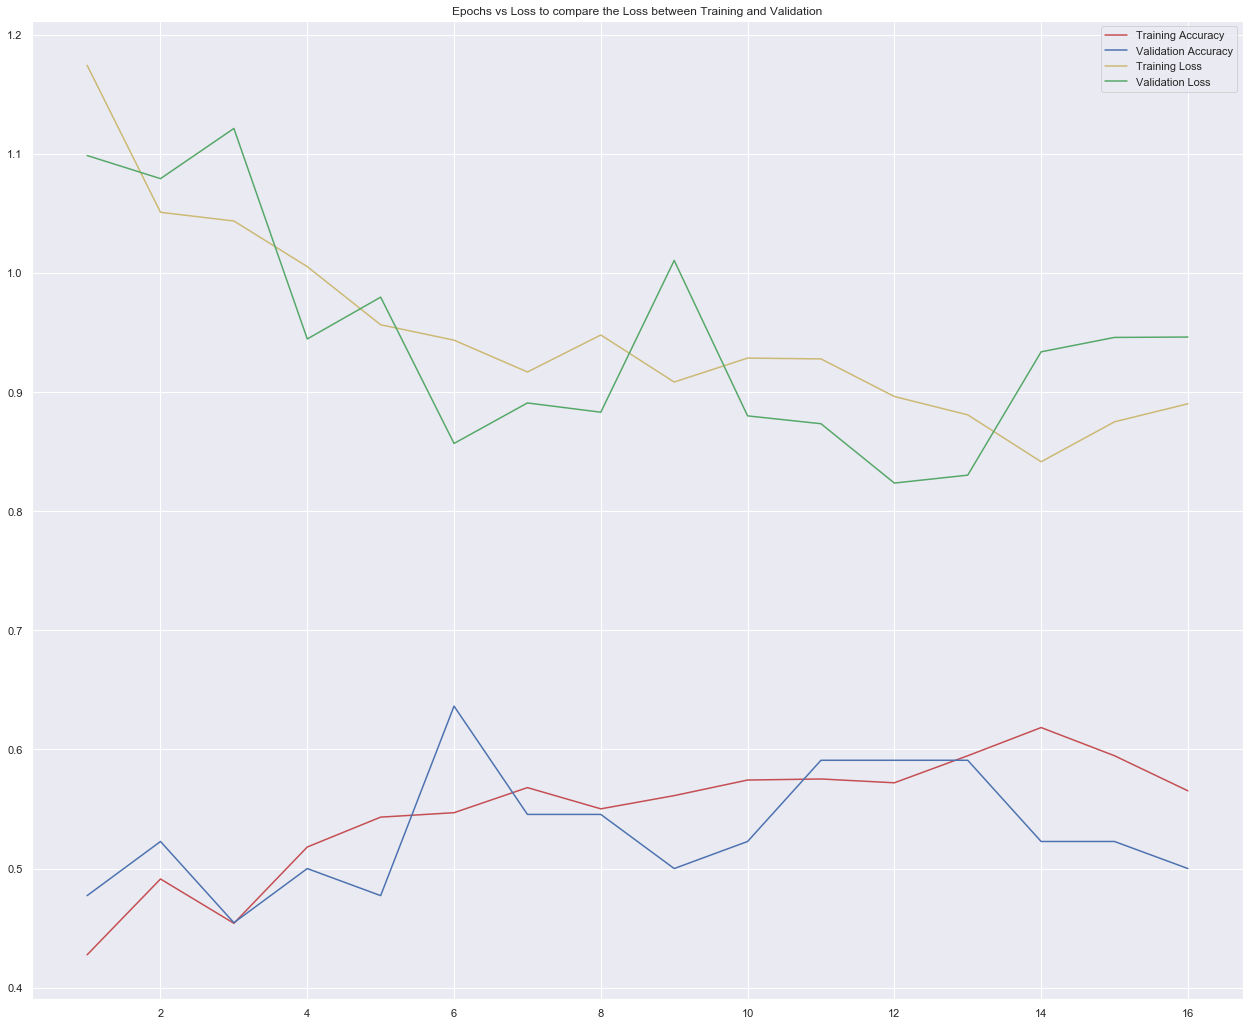

In [64]:
plot(history_5)

In [65]:
groceries_model_5 = models.load_model('h5 files\groceries_5.h5')

In [66]:
test_gen, X_test, y_test = test_list(4)
predict_and_evaluate(test_gen, X_test, y_test, groceries_model_5)

[2 2 2 0 2 0 2 2 2 0 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 0 0 0 2 2 2 2 0 2 2 1 2
 2 2 2 1 2 2 2 2 2 1 2 2 2 2 0 2 0 2 2 2 0 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 0
 0 0 2 2 2 2 0 2 2 1 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 0 2 0 2 2 2 0 2 2 1 1 2
 2 2 2 2 2 2 2 1 2 2 0 0 0 2 2 2 2 0 2 2 1 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 0
 2 0 2 2 2 0 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 0 0 0 2 2 2 2 0 2 2 1 2 2 2 2 1
 2 2 2 2 2 1 2 2 2 2 0 2 0 2 2 2 0 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 0 0 0 2 2
 2 2 0 2 2 1 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 0 2 0 2 2 2 0 2 2 1 1 2 2 2 2 2
 2 2 2 1 2 2 0 0 0 2 2 2 2 0 2 2 1 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 0 2 0 2 2
 2 0 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 0 0 0 2 2 2 2 0 2 2 1 2 2 2 2 1 2 2 2 2
 2 1 2 2 2 2 0 2 0 2 2 2 0 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 0 0 0 2 2 2 2 0 2
 2 1 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 0 2 0 2 2 2 0 2 2 1 1 2 2 2 2 2 2 2 2 1
 2 2 0 0 0 2 2 2 2 0 2 2 1 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 0 2 0 2 2 2 0 2 2
 1 1 2 2 2 2 2 2 2 2 1 2 2 0 0 0 2 2 2 2 0 2 2 1 2 2 2 2 1 2 2 2 2 2 1 2 2
 2 2 0 2 0 2 2 2 0 2 2 1 

48/48 [==============================] - 0s 10ms/step
evaluate:  [6.127791404724121, 0.5833333333333334]
['loss', 'acc']


In [87]:
#---------------------------------------------------MODEL 6-----------------------------------------------------------#

In [88]:
gc.collect()
K.clear_session()

In [89]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [90]:
train_gen_6, val_gen_6, train_len, val_len = data_augmentation(X, y, 5)
groceries_model_6 = vgg16_model(y, 5, neurons_2)
groceries_model_6.summary()

[0 1 2]

[0 1 2]


X_TRAIN LENGTH:  432
X_VAL LENGTH:  49
Y_TRAIN LENGTH:  432
Y_VAL LENGTH:  49

7
7

X_train.shape():  (432, 100, 100, 3)
X_val.shape():  (49, 100, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None

C:\Users\rps24\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [91]:
groceries_model_6.compile(loss='sparse_categorical_crossentropy', optimizer = optimizers.Adam(lr=1e-4), metrics = ['acc'])

In [92]:
checkpoint = ModelCheckpoint("h5 files\groceries_6.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')

In [93]:
history_6 = groceries_model_6.fit_generator(generator= train_gen_6, 
                                 steps_per_epoch= train_len//batch_size_1, 
                                 epochs= batch_size_1, 
                                 validation_data= val_gen_6, 
                                 validation_steps=val_len//batch_size_1, 
                                 callbacks=[checkpoint,early])

Epoch 1/16
27/27 [==============================] - 4s 137ms/step - loss: 1.1480 - acc: 0.4319 - val_loss: 0.9947 - val_acc: 0.5556

Epoch 00001: val_acc improved from -inf to 0.55556, saving model to h5 files\groceries_6.h5
Epoch 2/16
27/27 [==============================] - 3s 125ms/step - loss: 1.0698 - acc: 0.4687 - val_loss: 0.9108 - val_acc: 0.5432

Epoch 00002: val_acc did not improve from 0.55556
Epoch 3/16
27/27 [==============================] - 3s 124ms/step - loss: 1.0099 - acc: 0.4988 - val_loss: 0.8635 - val_acc: 0.6049

Epoch 00003: val_acc improved from 0.55556 to 0.60494, saving model to h5 files\groceries_6.h5
Epoch 4/16
27/27 [==============================] - 3s 122ms/step - loss: 1.0505 - acc: 0.4839 - val_loss: 0.8633 - val_acc: 0.6296

Epoch 00004: val_acc improved from 0.60494 to 0.62963, saving model to h5 files\groceries_6.h5
Epoch 5/16
27/27 [==============================] - 3s 119ms/step - loss: 0.9968 - acc: 0.4919 - val_loss: 0.8913 - val_acc: 0.5679

Epo

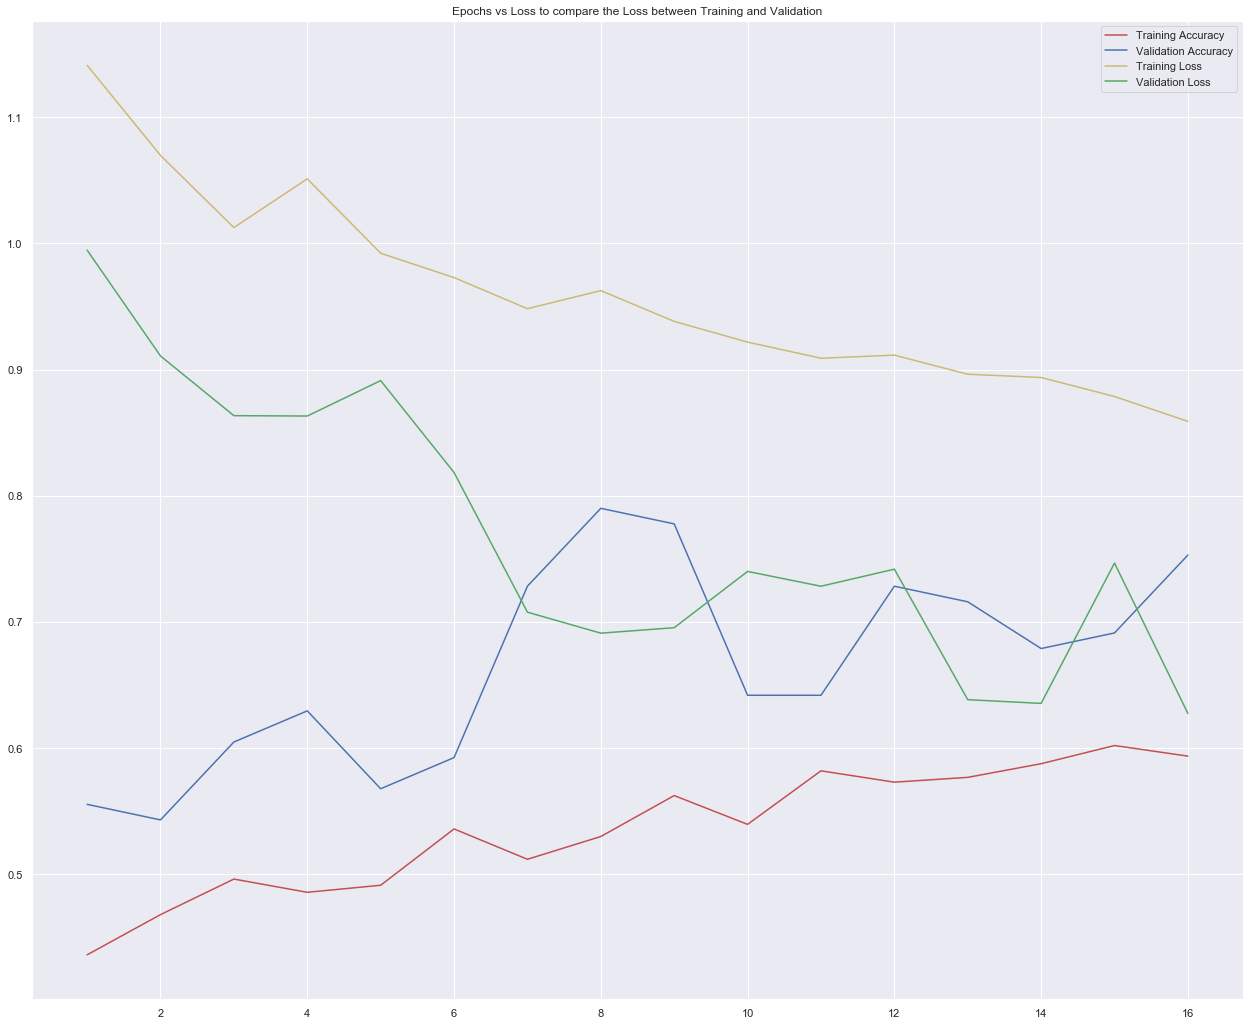

In [94]:
plot(history_6)

In [95]:
groceries_model_6 = models.load_model('h5 files\groceries_6.h5')

In [96]:
test_gen, X_test, y_test = test_list(5)
predict_and_evaluate(test_gen, X_test, y_test, groceries_model_6)

[2 2 2 0 2 0 2 0 2 0 0 2 0 0 2 2 2 1 2 2 2 0 2 0 0 2 2 2 2 2 0 1 2 2 2 2 0
 0 2 2 2 2 0 2 0 0 1 0 1 2 2 0 2 2 2 2 0 2 0 2 0 2 0 0 2 0 0 2 2 2 1 2 2 2
 0 2 0 0 2 2 2 2 2 0 1 2 2 2 2 0 0 2 2 2 2 0 2 0 0 1 0 1 2 2 0 2 2 2 2 0 2
 0 2 0 2 0 0 2 0 0 2 2 2 1 2 2 2 0 2 0 0 2 2 2 2 2 0 1 2 2 2 2 0 0 2 2 2 2
 0 2 0 0 1 0 1 2 2 0 2 2 2 2 0 2 0 2 0 2 0 0 2 0 0 2 2 2 1 2 2 2 0 2 0 0 2
 2 2 2 2 0 1 2 2 2 2 0 0 2 2 2 2 0 2 0 0 1 0 1 2 2 0 2 2 2 2 0 2 0 2 0 2 0
 0 2 0 0 2 2 2 1 2 2 2 0 2 0 0 2 2 2 2 2 0 1 2 2 2 2 0 0 2 2 2 2 0 2 0 0 1
 0 1 2 2 0 2 2 2 2 0 2 0 2 0 2 0 0 2 0 0 2 2 2 1 2 2 2 0 2 0 0 2 2 2 2 2 0
 1 2 2 2 2 0 0 2 2 2 2 0 2 0 0 1 0 1 2 2 0 2 2 2 2 0 2 0 2 0 2 0 0 2 0 0 2
 2 2 1 2 2 2 0 2 0 0 2 2 2 2 2 0 1 2 2 2 2 0 0 2 2 2 2 0 2 0 0 1 0 1 2 2 0
 2 2 2 2 0 2 0 2 0 2 0 0 2 0 0 2 2 2 1 2 2 2 0 2 0 0 2 2 2 2 2 0 1 2 2 2 2
 0 0 2 2 2 2 0 2 0 0 1 0 1 2 2 0 2 2 2 2 0 2 0 2 0 2 0 0 2 0 0 2 2 2 1 2 2
 2 0 2 0 0 2 2 2 2 2 0 1 2 2 2 2 0 0 2 2 2 2 0 2 0 0 1 0 1 2 2 0 2 2 2 2 0
 2 0 2 0 2 0 0 2 0 0 2 2 

53/53 [==============================] - 0s 4ms/step
evaluate:  [5.71200903406683, 0.6415094429591917]
['loss', 'acc']


In [159]:
#---------------------------------------------------MODEL 7-----------------------------------------------------------#

In [77]:
gc.collect()
K.clear_session()

In [78]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [79]:
train_gen_7, val_gen_7, train_len, val_len = data_augmentation(X, y, 6)
groceries_model_7 = vgg16_model(y, 6, neurons_2)
groceries_model_7.summary()

['sugar' 'tea' 'tomato_sauce']

[0 1 2]


X_TRAIN LENGTH:  463
X_VAL LENGTH:  52
Y_TRAIN LENGTH:  463
Y_VAL LENGTH:  52

7
7

X_train.shape():  (463, 100, 100, 3)
X_val.shape():  (52, 100, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv

C:\Users\rps24\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [80]:
groceries_model_7.compile(loss='sparse_categorical_crossentropy', optimizer = optimizers.Adam(lr=1e-4), metrics = ['acc'])

In [81]:
checkpoint = ModelCheckpoint("h5 files\groceries_7.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')

In [82]:
history_7 = groceries_model_7.fit_generator(generator= train_gen_7, 
                                 steps_per_epoch= train_len//batch_size_2, 
                                 epochs= batch_size_2, 
                                 validation_data= val_gen_7, 
                                 validation_steps=val_len//batch_size_2, 
                                 callbacks=[checkpoint,early])

Epoch 1/32
14/14 [==============================] - 7s 535ms/step - loss: 1.0658 - acc: 0.5089 - val_loss: 1.1200 - val_acc: 0.4062

Epoch 00001: val_acc improved from -inf to 0.40625, saving model to h5 files\groceries_7.h5
Epoch 2/32
14/14 [==============================] - 5s 347ms/step - loss: 0.9330 - acc: 0.5876 - val_loss: 1.1290 - val_acc: 0.5312

Epoch 00002: val_acc improved from 0.40625 to 0.53125, saving model to h5 files\groceries_7.h5
Epoch 3/32
14/14 [==============================] - 5s 354ms/step - loss: 0.8783 - acc: 0.6028 - val_loss: 1.3729 - val_acc: 0.4688

Epoch 00003: val_acc did not improve from 0.53125
Epoch 4/32
14/14 [==============================] - 5s 368ms/step - loss: 0.9609 - acc: 0.5826 - val_loss: 1.1276 - val_acc: 0.5000

Epoch 00004: val_acc did not improve from 0.53125
Epoch 5/32
14/14 [==============================] - 5s 356ms/step - loss: 0.8723 - acc: 0.6195 - val_loss: 0.8869 - val_acc: 0.6250

Epoch 00005: val_acc improved from 0.53125 to 0.

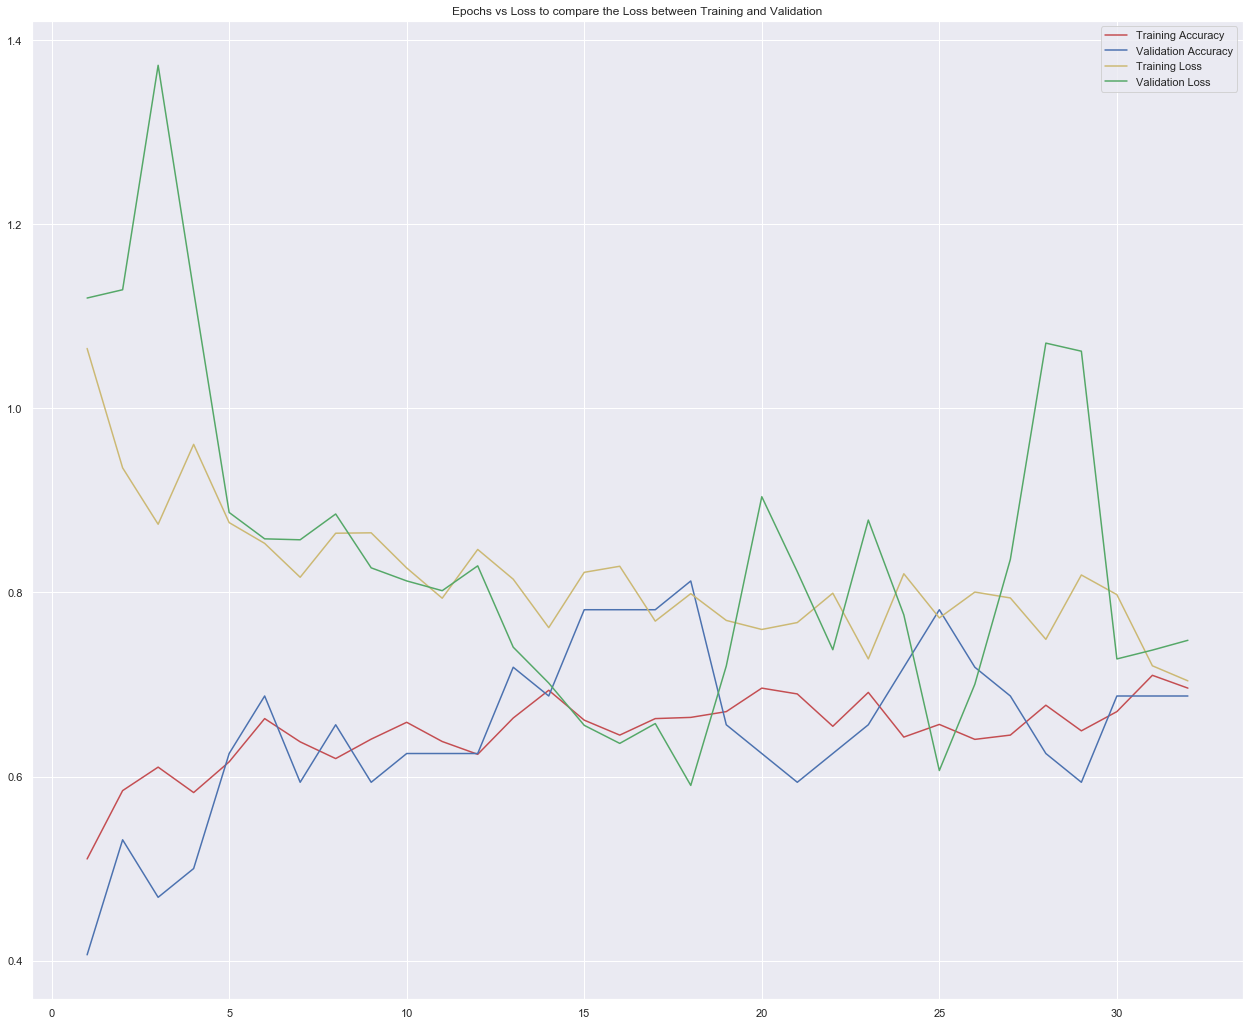

In [83]:
plot(history_7)

In [84]:
groceries_model_7 = models.load_model('h5 files\groceries_7.h5')

In [85]:
test_gen, X_test, y_test = test_list(6)
predict_and_evaluate(test_gen, X_test, y_test, groceries_model_7)

[1 1 0 1 1 1 2 2 2 2 2 2 0 1 1 1 2 0 2 1 2 0 2 1 2 0 2 1 1 2 2 1 0 2 2 2 1
 2 1 2 0 0 1 2 1 1 0 2 0 2 2 1 2 2 2 1 1 1 1 0 1 1 1 2 2 2 2 2 2 0 1 1 1 2
 0 2 1 2 0 2 1 2 0 2 1 1 2 2 1 0 2 2 2 1 2 1 2 0 0 1 2 1 1 0 2 0 2 2 1 2 2
 2 1 1 1 1 0 1 1 1 2 2 2 2 2 2 0 1 1 1 2 0 2 1 2 0 2 1 2 0 2 1 1 2 2 1 0 2
 2 2 1 2 1 2 0 0 1 2 1 1 0 2 0 2 2 1 2 2 2 1 1 1 1 0 1 1 1 2 2 2 2 2 2 0 1
 1 1 2 0 2 1 2 0 2 1 2 0 2 1 1 2 2 1 0 2 2 2 1 2 1 2 0 0 1 2 1 1 0 2 0 2 2
 1 2 2 2 1 1 1 1 0 1 1 1 2 2 2 2 2 2 0 1 1 1 2 0 2 1 2 0 2 1 2 0 2 1 1 2 2
 1 0 2 2 2 1 2 1 2 0 0 1 2 1 1 0 2 0 2 2 1 2 2 2 1 1 1 1 0 1 1 1 2 2 2 2 2
 2 0 1 1 1 2 0 2 1 2 0 2 1 2 0 2 1 1 2 2 1 0 2 2 2 1 2 1 2 0 0 1 2 1 1 0 2
 0 2 2 1 2 2 2 1 1 1 1 0 1 1 1 2 2 2 2 2 2 0 1 1 1 2 0 2 1 2 0 2 1 2 0 2 1
 1 2 2 1 0 2 2 2 1 2 1 2 0 0 1 2 1 1 0 2 0 2 2 1 2 2 2 1 1 1 1 0 1 1 1 2 2
 2 2 2 2 0 1 1 1 2 0 2 1 2 0 2 1 2 0 2 1 1 2 2 1 0 2 2 2 1 2 1 2 0 0 1 2 1
 1 0 2 0 2 2 1 2 2 2 1 1 1 1 0 1 1 1 2 2 2 2 2 2 0 1 1 1 2 0 2 1 2 0 2 1 2
 0 2 1 1 2 2 1 0 2 2 2 1 

57/57 [==============================] - 1s 10ms/step
evaluate:  [4.383498651939526, 0.7017543985132586]
['loss', 'acc']


In [86]:
#sparse_categorical_entropy: typically used when classes are exclusive 
#or when the targets take integer values as opposed to hot encoded
# integer-based version of the categorical crossentropy loss function
#formula: L(theta) = - sum(ylog(y_hat)) for all y and yhat,
#fyi: yhat == estimated target, y is observed target
#theta == parameter

In [56]:
#optimisation: a way of improving the algorithm's performance wrt a learning rate 

In [57]:
#sdg optimiser: fullform --> stochastic gradient descent
#commonly used
#variant of gradient descent (first order optimisation technique to find local minima of a differential function)
#how different? --> computes only a small subset of randomly selected data
#sdg has the same performance of a gradient descent with a low learning rate
#formula: theta = theta - learningrate*change in cost function
#J(theta; x; y) -- > loss/cost/objective function
#theta == parameter

In [58]:
#adam optimiser: algorithm for gradient-based optimisation of stochastic cost function
#combines advantages of root mean square propogation (rmsprop) and adaptive gradient algorithm (AdaGrad)
#both of those are sdg extensions
#adam computes different adaptive learning rates for different parameters
#adam is from ADAptive Moment estimation, ergo the adaptive nature
#difference between adg and adam? adam doesn't maintaing a single learning rate
#adam is fast and effective

In [59]:
#values of model.predict() of groceries_1.h5, groceries_2.h5 and groceries_3.h5 may differ from groceries_4.h5 
#because the models were executed after a timeout 